## Resources

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=1o4WfSopO_Rp

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import dnnlib
import numpy as np
import PIL.Image
from PIL import Image
from dnnlib import tflib

In [2]:
tflib.init_tf()

In [3]:
G, D, Gs = pickle.load(open('./results/00002-sgan-ffhq-mars-1gpu/network-final.pkl','rb'))

In [4]:
print(G.input_shapes)
print(D.input_shapes)
print(Gs.input_shapes)

[[None, 512], [None, 0]]
[[None, 3, 512, 512], [None, 0]]
[[None, 512], [None, 0]]


In [ ]:
gw = np.clip(3840 // G.output_shape[3], 7, 32)
gh = np.clip(2160 // G.output_shape[2], 4, 32)
latents = np.random.randn(gw * gh, *G.input_shape[1:])

some functions:
https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=1o4WfSopO_Rp

In [ ]:
def interpolate(A, B, num_interps):
    alphas = np.linspace(0, 1, num_interps)
    if A.shape != B.shape:
        raise ValueError('A and B must have the same shape to interpolate.')
    return np.array([(1-a)*A + a*B for a in alphas])


def imgrid(imarray, cols=5, pad=1):
    if imarray.dtype != np.uint8:
        raise ValueError('imgrid input imarray must be uint8')
    pad = int(pad)
    assert pad >= 0
    cols = int(cols)
    assert cols >= 1
    N, H, W, C = imarray.shape
    rows = int(np.ceil(N / float(cols)))
    batch_pad = rows * cols - N
    assert batch_pad >= 0
    post_pad = [batch_pad, pad, pad, 0]
    pad_arg = [[0, p] for p in post_pad]
    imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
    H += pad
    W += pad
    grid = (imarray
            .reshape(rows, cols, H, W, C)
            .transpose(0, 2, 1, 3, 4)
            .reshape(rows*H, cols*W, C))
    if pad:
        grid = grid[:-pad, :-pad]
    return grid


def imshow(a, format='png', jpeg_fallback=True):
    a = np.asarray(a, dtype=np.uint8)
    #str_file = cStringIO.StringIO()
    PIL.Image.fromarray(a).save(str_file, format)
    im_data = str_file.getvalue()
    try:
        disp = IPython.display.display(IPython.display.Image(im_data))
    except IOError:
        if jpeg_fallback and format != 'jpeg':
            print ('Warning: image was too large to display in format "{}"; '
                   'trying jpeg instead.').format(format)
            return imshow(a, format='jpeg')
        else:
            raise
    return disp

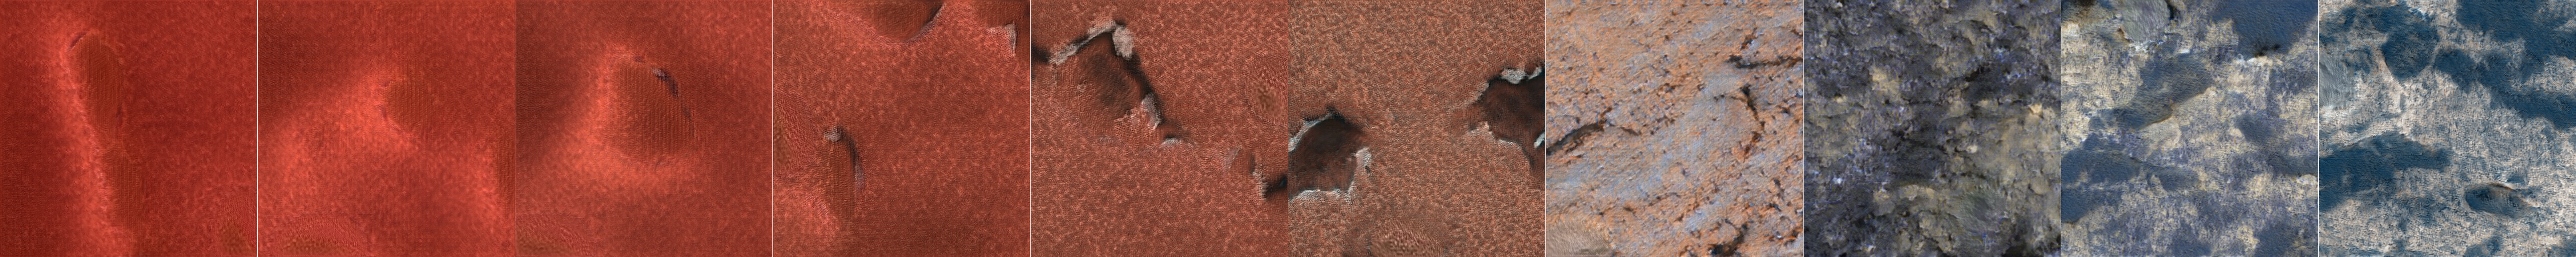

In [ ]:
interpolates = interpolate(np.random.randn(1, *G.input_shape[1:])[0], np.random.randn(1, *G.input_shape[1:])[0],10)
fakes = Gs.run(interpolates, latents.shape, minibatch_size=8)
for i,fa in enumerate(fakes):
    t1 = (fa-fa.min())
    t2 = ((t1/np.max(t1)*255).astype(np.uint8))
    fakes[i] = t2
fakes = fakes.astype(np.uint8)
image_grid = imgrid(fakes, cols=10, pad=1)
im = Image.fromarray(image_grid.T)
im

In [ ]:
im.size

(5129, 512)

In [ ]:
#im.save('./interpolate_5.png')

### generate stack of images

In [ ]:
number = 8
progressions = []
for n in range(number):
    interpolates = interpolate(np.random.randn(1, *G.input_shape[1:])[0], np.random.randn(1, *G.input_shape[1:])[0],10)
    fakes = Gs.run(interpolates, latents.shape, minibatch_size=8)
    for i,fa in enumerate(fakes):
        t1 = (fa-fa.min())
        t2 = ((t1/np.max(t1)*255).astype(np.uint8))
        fakes[i] = t2
    fakes = fakes.astype(np.uint8)
    image_grid = imgrid(fakes, cols=10, pad=1)
    progressions.append(image_grid.T)
progressions = np.vstack(progressions)
#image_grid = imgrid(fakes, cols=10, pad=1)
im = Image.fromarray(progressions)
im



In [ ]:
progressions.shape

In [ ]:
# im.save('progression.png')

## Stack vertically images

In [ ]:
# import sys
# from PIL import Image

# images = [Image.open('./interpolate_1.png'), 
#           Image.open('./interpolate_2.png'),
#           Image.open('./interpolate_3.png'),
#          Image.open('./interpolate_4.png'),
#          Image.open('./interpolate_5.png'),]
# widths, heights = zip(*(i.size for i in images))

# total_heigth = sum(heights)
# total_width = sum(widths)
# max_height = max(heights)
# max_width = max(widths)

# new_im = Image.new('RGB', (max_width, total_heigth))
# print(new_im.size)
# offset = 0
# for im in images:
#     print(im.size)
#     new_im.paste(im, (0,offset))
#     offset += im.size[1]
# new_im

In [ ]:
# new_im.save('Interpolate_all.png')

## Generate and plot single image

In [ ]:
latents = np.random.randn(1, *G.input_shape[1:])
fake = Gs.run(latents, latents.shape, minibatch_size=8)
fa = fake[0]
t1 = (fa-fa.min())
t2 = ((t1/np.max(t1)*255).astype(np.uint8))
plt.figure(figsize=(7,2))
plt.plot(latents[0])
plt.tight_layout()
plt.figure(figsize=(7,7))
plt.imshow(t2.T)
plt.tight_layout()